In [1]:
%load_ext autoreload
%autoreload 2

from dataset import VOCABULARY, NUM_MIDI_NOTES
from model import NoteComposeNet

import numpy as np
import pretty_midi
import torch
import matplotlib.pyplot as plt
%matplotlib inline 

import librosa

In [2]:
SKIP_EOS = True # If true, ignores any EOS tokens

In [3]:
# Load model. Potentially load some weights as well.

model = NoteComposeNet()

# PATH = r"./checkpoints/model_20230801_064431_0"
# model.load_state_dict(torch.load(PATH))

In [5]:
toks = model.generate(np.array([VOCABULARY["BOS"]], dtype=int), max_len=1000, temperature=1)
print(model.detokenize(toks))

['B0', 'D5', 'G♯3', 'G6', 'A♯3', 'A♯-1', 'D1', 'D♯9', 'B3', 'C7', 'G0', 'G♯5', 'D4', 'G♯1', 'B6', 'G7', 'E2', 'G-1', 'A♯0', 'G7', 'G0', 'EOS', 'G♯5', 'C♯6', 'A♯7', 'C2', 'B3', 'G♯5', 'B3', 'A♯8', 'C6', 'SEP', 'E2', 'F8', 'D4', 'B5', 'MASK', 'A0', 'G3', 'F0', 'D♯1', 'F♯-1', 'F5', 'C♯5', 'C1', 'F-1', 'G♯5', 'A♯8', 'F♯8', 'D8', 'G-1', 'E7', 'C3', 'E9', 'EOS', 'C♯5', 'D7', 'A3', 'G♯4', 'F1', 'A5', 'C5', 'B6', 'E4', 'C♯3', 'B7', 'D♯0', 'D♯9', 'G5', 'B-1', 'D1', 'D♯0', 'B2', 'F0', 'D♯1', 'G♯-1', 'F5', 'B4', 'F♯8', 'EOS', 'B-1', 'C♯5', 'G♯3', 'G9', 'B2', 'G8', 'D0', 'C6', 'F♯2', 'F6', 'C♯6', 'E-1', 'F3', 'C6', 'D-1', 'F9', 'D7', 'E1', 'G6', 'F3', 'B3', 'E8', 'G♯2', 'G5', 'B7', 'BOS', 'E8', 'B3', 'F5', 'F6', 'D0', 'BOS', 'F♯1', 'D-1', 'E9', 'C♯-1', 'F♯5', 'G5', 'F4', 'G5', 'E3', 'G7', 'A♯0', 'B7', 'G4', 'C♯0', 'B6', 'C♯5', 'A0', 'A♯4', 'C♯8', 'C4', 'C6', 'D6', 'C♯5', 'A0', 'D9', 'F♯3', 'B5', 'E2', 'D♯3', 'E4', 'D7', 'D♯9', 'C♯5', 'F♯6', 'C6', 'G♯2', 'D♯1', 'F♯0', 'C3', 'G♯0', 'B8', 'A-1', 'G♯4

In [ ]:
print(pretty_midi.INSTRUMENT_MAP)

['Acoustic Grand Piano', 'Bright Acoustic Piano', 'Electric Grand Piano', 'Honky-tonk Piano', 'Electric Piano 1', 'Electric Piano 2', 'Harpsichord', 'Clavinet', 'Celesta', 'Glockenspiel', 'Music Box', 'Vibraphone', 'Marimba', 'Xylophone', 'Tubular Bells', 'Dulcimer', 'Drawbar Organ', 'Percussive Organ', 'Rock Organ', 'Church Organ', 'Reed Organ', 'Accordion', 'Harmonica', 'Tango Accordion', 'Acoustic Guitar (nylon)', 'Acoustic Guitar (steel)', 'Electric Guitar (jazz)', 'Electric Guitar (clean)', 'Electric Guitar (muted)', 'Overdriven Guitar', 'Distortion Guitar', 'Guitar Harmonics', 'Acoustic Bass', 'Electric Bass (finger)', 'Electric Bass (pick)', 'Fretless Bass', 'Slap Bass 1', 'Slap Bass 2', 'Synth Bass 1', 'Synth Bass 2', 'Violin', 'Viola', 'Cello', 'Contrabass', 'Tremolo Strings', 'Pizzicato Strings', 'Orchestral Harp', 'Timpani', 'String Ensemble 1', 'String Ensemble 2', 'Synth Strings 1', 'Synth Strings 2', 'Choir Aahs', 'Voice Oohs', 'Synth Choir', 'Orchestra Hit', 'Trumpet', '

In [15]:
midi_file = pretty_midi.PrettyMIDI()

piano = pretty_midi.Instrument(0)

time = 0
for tok in toks:
    duration = .125

    if tok < NUM_MIDI_NOTES:
        note = pretty_midi.Note(velocity=100, pitch=tok, start=time, end=time + duration)
    elif tok == VOCABULARY['EOS']:
        if not SKIP_EOS:
            break # Stop Generating for EOS
        else:
            time += duration
    elif tok == VOCABULARY['SEP']:
        time += duration # Simply add a new time    
    else:
        continue

    piano.notes.append(note)

midi_file.instruments.append(piano)

midi_file.write("my_midi.mid")

C:\Users\Joaquin\AppData\Local\Temp\ipykernel_14956\3232774524.py:4: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(midi_file.get_piano_roll(fs),


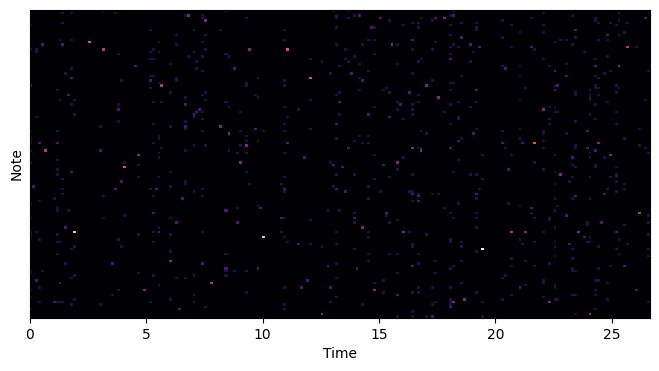

In [16]:
fs = 100

plt.figure(figsize=(8, 4))
librosa.display.specshow(midi_file.get_piano_roll(fs),
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note')
plt.show()
